In [17]:
# Skip cell (weird vscode bug)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import copy
import pygem_eb.processing.gridsearch_processing as gsproc
import pygem_eb.processing.gridsearch_plotting as gsplot

In [2]:
# ===== GET RESULTS DICT =====
# gsproc.process_runs('long', sites='all')                # This function re-creates each individual run .pkl and thus takes ~60 minutes in series
result_dict = gsproc.get_result_dict(force_redo=False)     # Add force_redo=True to recompile the result dictionaries

In [4]:
# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['2024','snowdensity','winter','summer','snowdepth','annual']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims)

In [5]:
# ===== DEFINE LIST OF ERRORS TO PERFORM CALIBRATION =====
error_list = ['summer','winter','snowdensity','snowdepth']

In [6]:
# ===== FIND PARETO FRONTS AND PLOT AN EXAMPLE =====
all_bootstrap_pareto, all_calib, all_valid, optima = gsproc.get_pareto_fronts_bootstrap(100, result_dict, error_list, return_validation=True, return_optima=True)
all_pareto_flat = list(set(list(itertools.chain(*all_bootstrap_pareto))))
# gsplot.plot_pareto_fronts(error_list, result_dict, split=1)

One iteration takes 0.58 seconds


In [6]:
all_bootstrap_pareto_seasonal = gsproc.get_pareto_fronts_bootstrap(100, result_dict, ['summer','winter'])
frequency_dict_seasonal, _ = gsproc.get_frequency(all_bootstrap_pareto_seasonal)

all_bootstrap_pareto_annual = gsproc.get_pareto_fronts_bootstrap(100, result_dict, ['annual'])
frequency_dict_annual, _ = gsproc.get_frequency(all_bootstrap_pareto_annual)

One iteration takes 0.06 seconds
One iteration takes 0.03 seconds


In [10]:
# ===== WEIGHT AND FIND THE BEST =====
best_by = gsproc.get_best_normalized(error_list, result_dict, prints=True, site='mean')
best = best_by[-1]

Weights:
    summer     winter snowdensity  snowdepth     best
         1          0          0          0      ('0.028', '2')
         0          1          0          0      ('0.02', '2.25')
         0          0          1          0      ('0.023', '3')
         0          0          0          1      ('0.018', '2.625')
      0.25       0.25       0.25       0.25      ('0.024', '2.25')


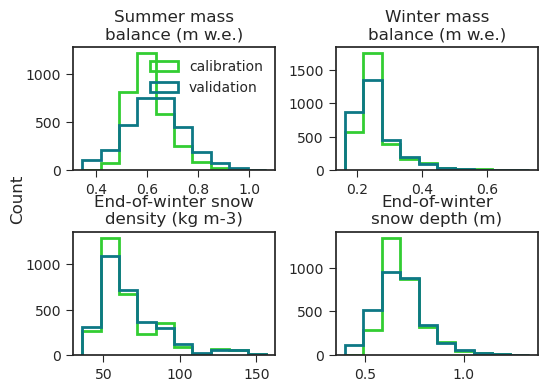

In [9]:
# ===== COMPARE VALIDATION TO CALIBRATION =====
gsplot.compare_calib_valid(error_list, all_calib, all_valid, savefig=True)

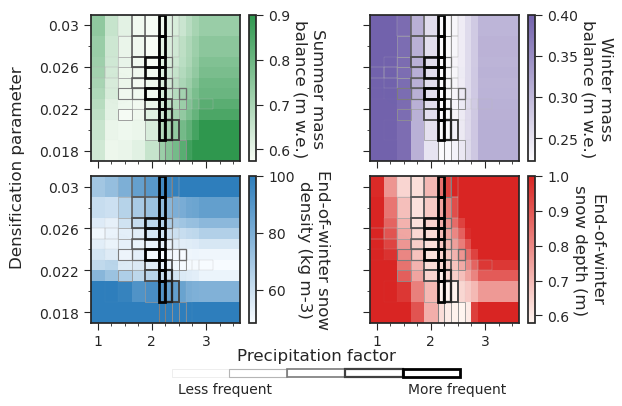

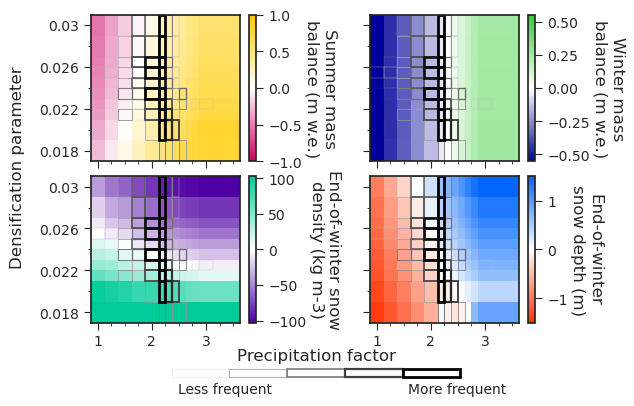

In [8]:
frequency_dict, _ = gsproc.get_frequency(all_bootstrap_pareto)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='MAE', optima=optima)
gsplot.plot_pareto_heatmap(frequency_dict, result_dict, error_list, savefig=True, metric='ME', optima=optima)

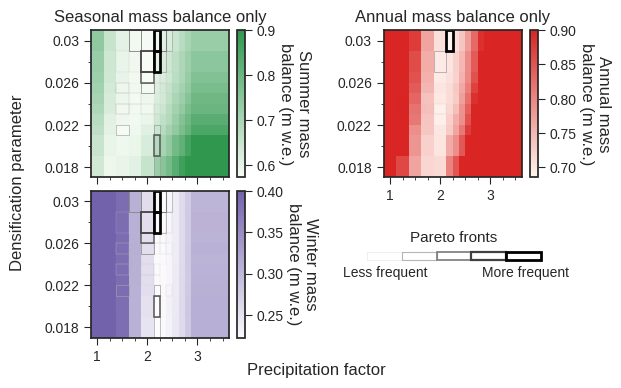

In [33]:
fig = plt.figure(figsize=(6,4))
gs = mpl.gridspec.GridSpec(4,2, figure=fig, wspace=0.7, hspace=0.2)

# Generate subplots for seasonal 
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax_left = [ax1,ax2]
# Plot heatmap
fig, ax_left = gsplot.plot_pareto_heatmap(frequency_dict_seasonal, result_dict, ['summer','winter'], savefig=False, metric='MAE', figaxes = (fig, ax_left), legend=False)
# Labeling
ax_left[0].set_xticklabels(['','',''])
ax_left[0].set_title('Seasonal mass balance only', fontsize=12)
ax_left[1].set_title('')

# Generate subplot for annual
ax_right = fig.add_subplot(gs[0:2, 1])
# Plot heatmap
fig, ax_right = gsplot.plot_pareto_heatmap(frequency_dict_annual, result_dict, ['annual'], savefig=False, metric='MAE', figaxes = (fig, [ax_right]), legend=False)
# Labeling
ax_right[0].set_title('Annual mass balance only', fontsize=12)

cax = fig.add_axes([0.58,0.3,0.3,0.03])
cmap = mpl.colormaps['Grays']
norm =  mpl.colors.Normalize(vmin=0,vmax=5)
boundaries = [1,2,3,4,5]
for b in boundaries:
    alpha = 1 - (5 - b)/5
    rect = mpl.patches.Rectangle((b, 0), 1, 1, linewidth=alpha*2, edgecolor=cmap(norm(b)), facecolor='none')
    cax.add_patch(rect)
border = 0.1
cax.set_xlim(np.min(boundaries) - border, np.max(boundaries) + 1 + border)
cax.set_ylim(-0.3,1.3)
cax.axis('off')
cax.text(0.3, -2.2, 'Less frequent')
cax.text(4.3, -2.2, 'More frequent')
cax.set_title('Pareto fronts',fontsize=11)

plt.savefig('/trace/group/rounce/cvwilson/Output/seasonal_annual_only_calibration.png', dpi=250, bbox_inches='tight')

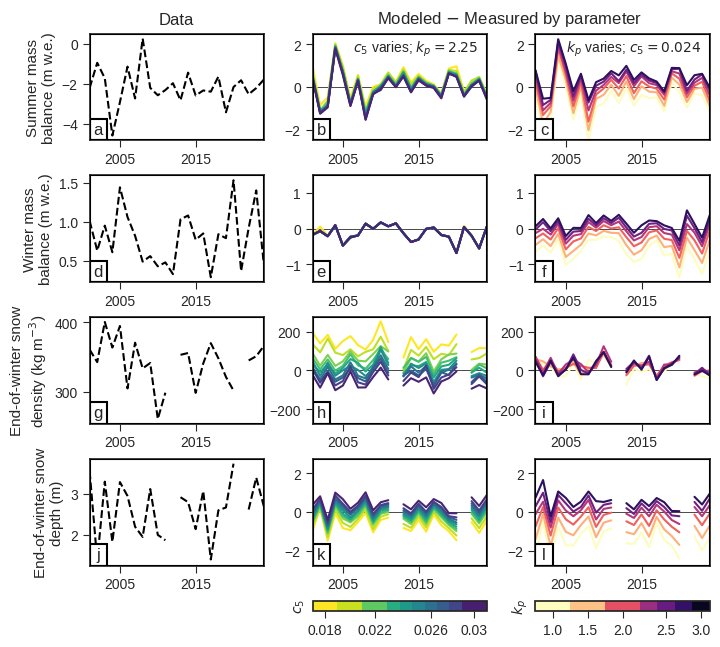

In [28]:
# ===== TRADEOFFS TIMESERIES=====
gsplot.plot_difference_by_param(best, result_dict, plot_vars=error_list, savefig=True)

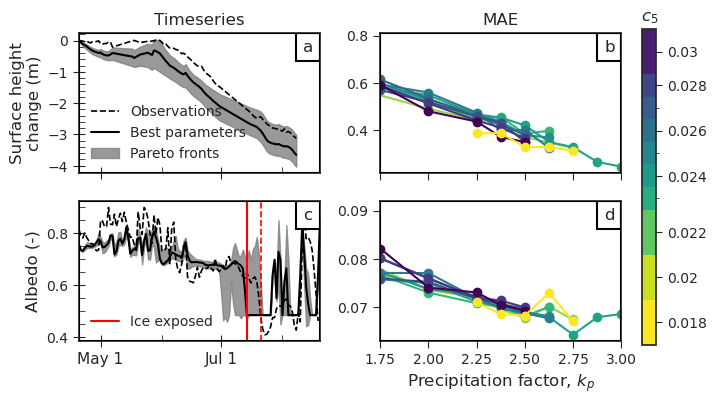

In [14]:
# ===== PLOT 2024 PARETO FRONT VALIDATION =====
gsplot.plot_pareto_2024(all_pareto_flat, result_dict, frequency_dict, best, savefig=True)

In [29]:
# ===== TRADEOFFS TIMESERIES FOR ONE RUN TYPE =====
# gsplot.plot_tradeoffs_2024(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_annual(result_dict, best_by[-1])
# gsplot.plot_tradeoffs_snowpits(result_dict, best_by[-1])

In [30]:
# ===== MULTI-PANEL TRADEOFFS =====
# gsplot.plot_tradeoffs(result_dict,error_list,savefig=True)
# gsplot.plot_tradeoffs(result_dict,error_list,savefig=True,metric='ME')

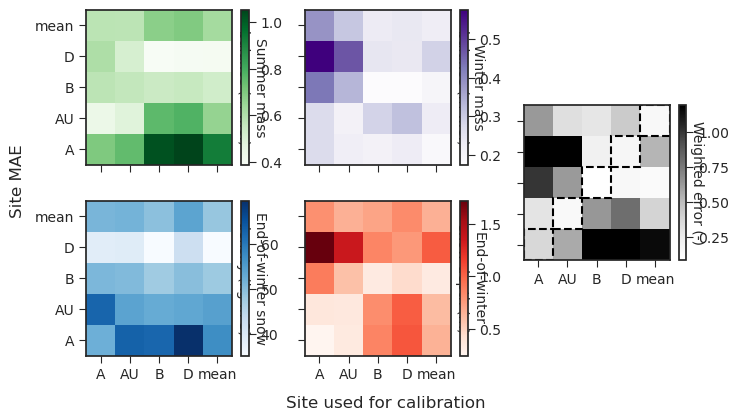

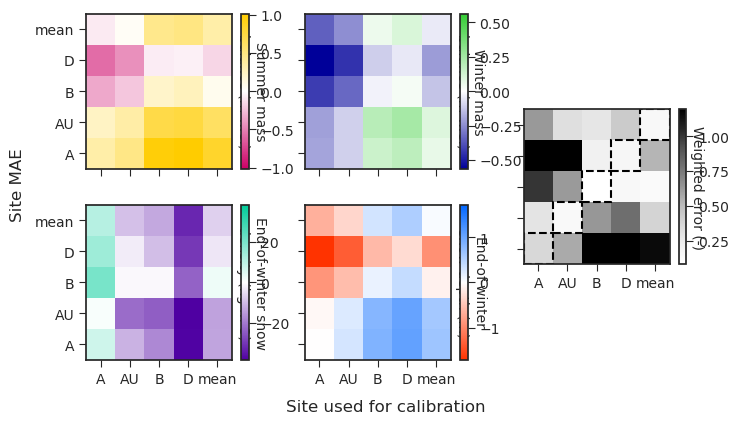

In [20]:
# ===== CALIBRATE ON ONE SITE =====
# gsplot.plot_heatmap_by_site(error_list, result_dict)
# gsplot.plot_best_by_site(error_list, result_dict)
error_list_heatmap = error_list + ['weighted']
gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='MAE', savefig=True)
gsplot.plot_heatmap_by_site_weighted(error_list_heatmap, result_dict, metric='ME', savefig=True)

In [32]:
# ===== PLOT A SINGLE RUN =====
# gsplot.plot_best_seasonal(best, result_dict, savefig=True)
# gsplot.plot_best_2024(best, result_dict, savefig=True)
# gsplot.plot_best_snowpits(best_by[-1], result_dict, savefig=True)
# gsplot.plot_best_snowmass(best_by[-1], result_dict) 
# gsplot.plot_best_albedo(best, result_dict, savefig=True)

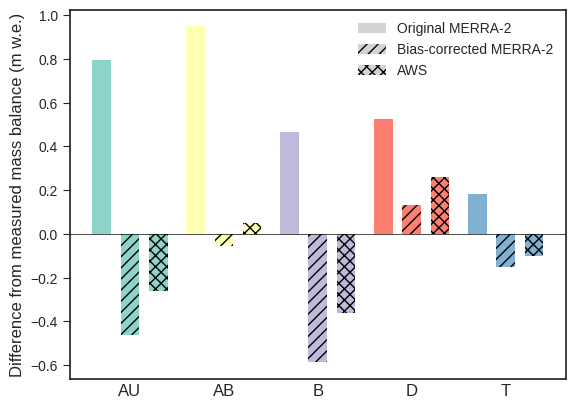

In [88]:
with open('/trace/group/rounce/cvwilson/Output/bias_correct/bias_correction_test.pkl', 'rb') as f:
    mb_dict = pickle.load(f)
gsplot.plot_bias_correction(mb_dict, True)

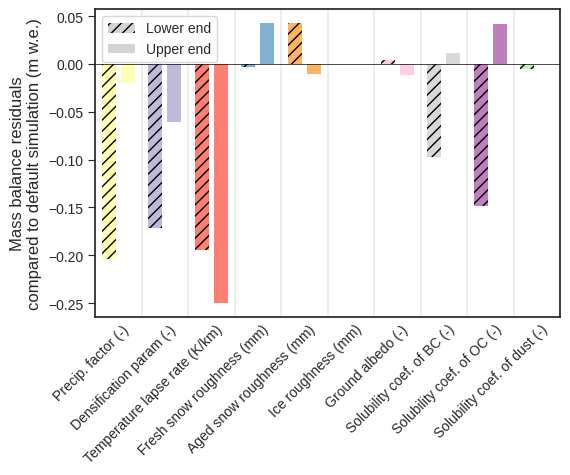

In [2]:
with open('/trace/group/rounce/cvwilson/Output/sensitivity/sensitivity_test.pkl','rb') as f:
    sens_dict = pickle.load(f)
gsplot.plot_sensitivity(sens_dict, savefig=True)

-2.6225946551162505 0.2615644909817811 0.057891252932067684
-2.6507472032429455 0.3556036926958005 0.05645362519534524
-2.7733750655573464 0.26156449098178103 0.04959299093414922


(-0.1, 3.0)

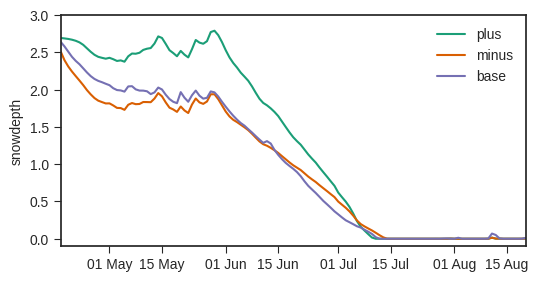

In [31]:
ds1 =xr.open_dataset('/trace/group/rounce/cvwilson/Output/sensitivity/Boone-c5_-20_1.nc')
ds2 =xr.open_dataset('/trace/group/rounce/cvwilson/Output/sensitivity/Boone-c5_+20_1.nc')
ds3 =xr.open_dataset('/trace/group/rounce/cvwilson/Output/sensitivity/base_0.nc')
# visualize_layers(ds1, pd.date_range('2024-04-20','2024-08-20'), ['layerdensity'])
# visualize_layers(ds2, pd.date_range('2024-04-20','2024-08-20'), ['layerdensity'])
# visualize_layers(ds3, pd.date_range('2024-04-20','2024-08-20'), ['layerdensity'])
print(-ds1.melt.sum().values , ds1.accum.sum().values , ds1.refreeze.sum().values)
print(-ds3.melt.sum().values , ds3.accum.sum().values , ds3.refreeze.sum().values)
print(-ds2.melt.sum().values , ds2.accum.sum().values , ds2.refreeze.sum().values)


fig, ax = compare_runs([ds2,ds1,ds3],[ds1.time.values[0], ds1.time.values[-1]],['plus','minus','base'],'snowdepth')
ax.set_ylim(-0.1, 3)

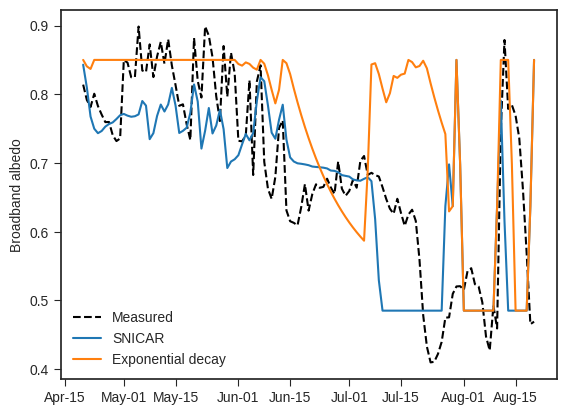

In [16]:
ds_SNICAR = xr.open_dataset('../Output/EB/Gulkana_2025_05_08_0.nc')
ds_exp = xr.open_dataset('../Output/EB/Gulkana_2025_05_08_3.nc')
dates, snicar, data = daily_albedo(ds_SNICAR, out='data')
dates, exp, data = daily_albedo(ds_exp, out='data')

fig,ax = plt.subplots()
ax.plot(dates, data, color='k', linestyle='--',label='Measured')
ax.plot(dates, snicar, label='SNICAR')
ax.plot(dates, exp, label='Exponential decay')
ax.set_ylabel('Broadband albedo')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.legend()
ax.tick_params(length=5)
plt.show()

OUTDATED METHODS BEFORE I APPLIED BOOTSTRAPPING

In [ ]:
# OUTDATED --- THIS WAS HOW I DID IT BEFORE BOOTSTRAPPING
# 
# ===== PARETO FRONTS ======
# get_pareto_fronts = True
# plot_pareto_fronts = True
# metric = 'ME'
# site = 'mean'

# if get_pareto_fronts:
#     # Retrieve all pareto fronts
#     all_pareto_fronts = gsplot.get_pareto_fronts(error_list,result_dict,plot=False,site=site)
#     all_pareto_fronts_flat = list(set(list(itertools.chain(*all_pareto_fronts))))
    
#     # Extract all kps and c5s
#     all_pareto_kp = np.sort(list(set([front[1] for front in all_pareto_fronts_flat])))
#     all_pareto_c5 = np.sort(list(set([front[0] for front in all_pareto_fronts_flat]))).astype(str).tolist()

#     # Determine which parameters are consistent across all comparisons
#     sets_of_tuples = [set(sublist) for sublist in all_pareto_fronts]
#     consistent_parameters = set.intersection(*sets_of_tuples)

# if plot_pareto_fronts:
#     gsplot.get_pareto_fronts(error_list,result_dict,plot=True,colored_param='c5',site=site)
#     # gsplot.get_pareto_fronts(error_list,result_dict,plot=True,colored_param='kp')
#     # gsplot.plot_pareto_PMF(error_list,all_pareto_fronts_flat,result_dict,metric+'_valid')
#     # gsplot.plot_pareto_params(all_pareto_fronts_flat)
#     gsplot.plot_pareto_heatmap(all_pareto_fronts_flat, result_dict, error_list, metric=metric, savefig=False, site=site)

# # ===== WEIGHT PARAMETERS AND FIND BEST =====
# best_by = gsproc.get_best(error_list, result_dict, prints=True, site='median')
# best = best_by[-1]

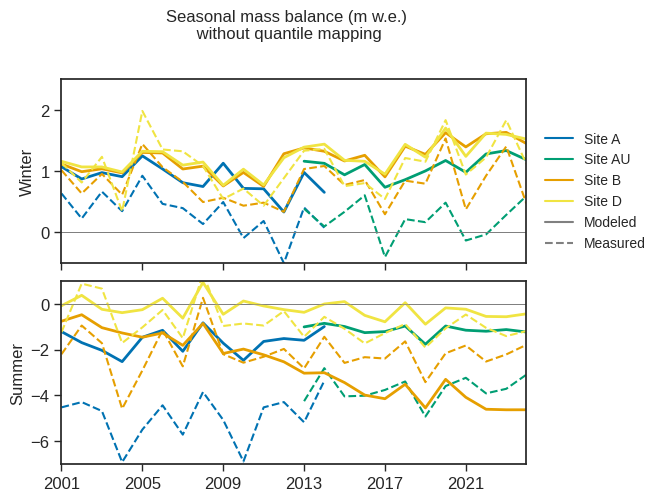

In [10]:
fig, axes = plt.subplots(2,figsize=(6,5),gridspec_kw={'hspace':0.1},sharex=True)
list_plots = []
sites = ['A','AU','B','D']
colors = np.flip(['#F0E442','#E69F00','#009E73','#0072B2']) #

for ss,site in enumerate(sites):   
    ds,s,e = getds(f'/trace/group/rounce/cvwilson/Output/Gulkana_2025_02_28_long{site}_0.nc')
    if site == 'B':
        bds = ds.copy()
    color = colors[ss]
    axes[0] = plot_seasonal_mass_balance(ds,plot_ax=axes[0],plot_var='bw',color=color)
    axes[1] = plot_seasonal_mass_balance(ds,plot_ax=axes[1],plot_var='bs',color=color)
    dummy_site, = axes[1].plot(np.nan,np.nan,color=color)
    list_plots.append(dummy_site)
dummy_model, = axes[1].plot(np.nan,np.nan,color='gray')
dummy_meas, = axes[1].plot(np.nan,np.nan,color='gray',linestyle='--')
list_plots.append(dummy_model)
list_plots.append(dummy_meas)
axes[0].set_ylabel('Winter',fontsize=12)
axes[1].set_ylabel('Summer',fontsize=12)
axes[0].set_ylim(-0.5,2.5)
axes[1].set_ylim(-7,1)
axes[1].set_yticks([0,-2,-4,-6])
for i in range(2):
    axes[i].get_legend().remove()
labels = ['Site '+sss for sss in sites]+['Modeled','Measured']
fig.legend(list_plots,labels,bbox_to_anchor=(1.12,0.8),fontsize=10)
fig.suptitle('Seasonal mass balance (m w.e.)\n without quantile mapping',fontsize=12,y=1.02)
plt.show()

In [ ]:
# base_fp = gsproc.base_fp
# for site in gsproc.sitedict['long']:
#     import time
#     start = time.time()
#     for kp in gsproc.params['kp']:
#         for c5 in gsproc.params['c5']:
#             date = gsproc.run_info['long']['date']
#             run_no = result_dict[c5][kp][site]['run_no']
#             set_no = result_dict[c5][kp][site]['set_no']
#             with open(base_fp + f'{date}_{site}_0/grid_{date}_set{set_no}_run{run_no}_0.pkl', 'rb') as file:
#                 run_dict = pickle.load(file)
#             ds = gsproc.get_any(result_dict,c5,kp,site)
#             years, data = snowpits(ds, out='data')
#             for var in data:
#                 run_dict[var] = data[var]
#             error_dict = snowpits(ds,method=['MAE','MdAE','ME'],out='mean_error')
#             for item in error_dict:
#                 run_dict[item] = error_dict[item]
#             with open(base_fp + f'{date}_{site}_0/grid_{date}_set{set_no}_run{run_no}_0.pkl', 'wb') as file:
#                 pickle.dump(run_dict, file)
#     print('done', site, 'in', time.time()-start)

# Below are functions I probably don't need but don't want to delete yet

ELEVATION DEPENDENCE

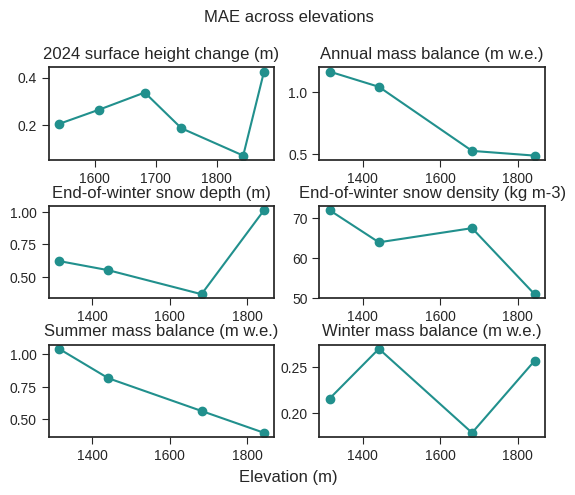

In [25]:
fig,axes = plt.subplots(3,2, gridspec_kw={'hspace':0.5, 'wspace':0.2})
axes = axes.flatten()
metric = 'MAE'
markers = ['o','^','*','x','+','>','v','s','D','2','4']
all_c5s = [float(x[0]) for x in all_pareto_fronts_flat]
norm = mpl.colors.Normalize(vmin=np.min(all_c5s),vmax=np.max(all_c5s))
cmap = mpl.colormaps.get_cmap('viridis_r')
for e,error_name in enumerate(['2024','annual','snowdepth','snowdensity','summer','winter']):
    run = '2024' if '2024' in error_name else 'long'
    date = run_info[run]['date']
    idx = run_info[run]['idx']
    
    for front in [best]: # all_pareto_fronts_flat:
        c5, kp = front
        kp = kp.replace('.0','')
        index_marker = params['kp'].index(kp)
        list_error = []
        list_elev = []
        for site in sitedict[run]:
            # Get elevation of the site
            df = pd.read_csv('~/research/PyGEM-EB/data/Gulkana/site_constants.csv',index_col='site')
            elevation = df.loc[site,'elevation']
            list_error.append(result_dict[c5][kp][site][error_name + '_' + metric])
            list_elev.append(elevation)
        axes[e].plot(list_elev, list_error, color=cmap(norm(float(c5))), marker=markers[0])
    axes[e].set_title(errorlabels[error_name])
    axes[e].tick_params(length=5)
fig.supxlabel('Elevation (m)')
fig.suptitle('MAE across elevations',y=1)
plt.show()

Snowpack ripening

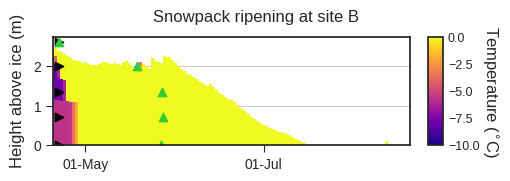

In [34]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
site = 'B'
ripe_dates = {}
# if site == 'AU':
#     ds,s,e = getds(f'~/research/Output/EB/Gulkana_2025_01_29_0.nc')
# else:
#     ds,s,e = getds(f'~/research/Output/EB/Gulkana_01_29_2024{site}_0.nc')
ds = gsproc.get_any('0.022','2.5',site,result_dict,'2024')

if site =='D':
    fig,ax = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp']) #,plot_firn=False)
else:
    fig,ax = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'])
# Scatter initial heights of iButtons
depths = np.array([f for f in ripe_dict[site]])
heights = depths[-1] - depths
start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
if site == 'D':
    heights += 700
ax.scatter(start,heights/100,color='black',marker='>',label='iButtons buried')

# Scatter ripened dates for each sensor
for depth in ripe_dict[site]:
    if site != 'B':
        height = 150 - depth
    else:
        height = 270 - depth
    if site == 'D':
        height += 700
    ax.scatter(ripe_dict[site][depth],height/100,marker='^',color='limegreen')
ax.scatter(np.nan,np.nan,marker='^',color='limegreen',label='iButtons ripe')
fig.suptitle('Snowpack ripening at site '+site)
plt.show()

Generate pits pickle

In [ ]:
site_profiles = {}
fp ='/trace/home/cvwilson/research/MB_data/Point/gulkana/pitcore/'
all_pits = os.listdir(fp)
for site in ['A','AU','B','D']:
    site_profiles[site] = {'sbd':{},'density':{},'date':{}}
    years= []
    dates = []
    density = []
    for f in all_pits:
        if '_' + site + '.' in f:
            try:
                df = pd.read_csv(fp+f)
            except:
                print('failed to read',fp+f)
                continue
            year = f.split('_')[1]
            try:
                int(year)
            except:
                year = f.split('Gulkana')[1][:4]
            if int(year) > 1999:
                date = f.split(str(year))[1][1:6].replace('.','-').replace('_','-')+'-'
                if '05' in date or '04' in date:
                    sbd = df['sample_bottom_depth']
                    density = df['sample_weight'] / df['volume']
                    site_profiles[site]['sbd'][int(year)] = sbd.values / 100
                    site_profiles[site]['density'][int(year)] = density.values
                    site_profiles[site]['date'][int(year)] = date
                    if year == '2012' and site == 'B':
                        print(f, density)

    for year in site_profiles[site]['sbd']:
        plt.plot(site_profiles[site]['density'][year],site_profiles[site]['sbd'][year], label=year)
    
#     plt.ylim(0)
#     plt.gca().invert_yaxis()
#     plt.title(site)
#     plt.legend()
#     plt.show()
# print(site_profiles)